# __Ocean regimes indicator__

Apply a Gaussian Mixtures Model to a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

ds_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import Plotter_OR
from Plotter_OR import Plotter_OR 

from BIC_calculation_OR import *

from preprocessing_OR import *

## Load dataset
***

- One year of SST data in the Mediterranean Sea:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'

- One year of SST data in the North Atlantic:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [ ]:
#file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1608215256580.nc'

- One year of Ocean Color data in the Mediterranean Sea:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082 product

In [ ]:
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1610026811620.nc'

Open dataset

In [3]:
ds = xr.open_dataset(file_path)
print(ds)
#ds

<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019...
  * lat                                            (lat) float32 30.12 ... 46.12
  * lon                                            (lon) float32 -4.875 ... 4...
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes: (12/52)
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  Development of a ...
    institut

In [ ]:
ds.lon.max()

In [5]:
#important to identify time variable
#ds['time'] = ds.indexes['time'].to_datetimeindex()
var_name = 'analysed_sst'

__Quick plot__

In [ ]:
ds[var_name].isel(time=11).plot();

In [ ]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values))
ds[var_name].plot.hist(bins=bins);

## Preprocessing
***

#### __1) Weekly mean for each pixel__

Weekly mean is useful for seasonal trends (lisser le signal): should it be an option?

In [6]:
X = OR_weekly_mean(ds, var_name=var_name)

#### __2) Reduce lat lon dimensions to sampling dimension__

In [7]:
X = OR_reduce_dims(X)

#### __3) Delate all NaN time series using mask__

In [8]:
X, mask = OR_delate_NaNs(X, var_name =var_name, mask_path='datasets/Mediterranean_mask_TEMP.nc')

In [ ]:
#plot mask
mask['mask'].plot();

#### __5) Scaler__

***

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

In [9]:
X = OR_scaler(X, var_name=var_name)

#### __5) PCA__

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [10]:
X = OR_apply_PCA(X, var_name=var_name)

In [ ]:
X

## Apply Model
***

__Create model__

In [11]:
from sklearn import mixture
k = 8 # number of classes
model = mixture.GaussianMixture(n_components=k, covariance_type='full')
model

GaussianMixture(n_components=8)

__Fit model__

In [12]:
model.fit(X[var_name + "_reduced"])

GaussianMixture(n_components=8)

__Predict labels__

In [13]:
X_labels = model.predict(X[var_name + "_reduced"])
X_labels

array([3, 3, 3, ..., 6, 6, 6])

In [14]:
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 16, sampling: 3914)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 45.62 45.62
  - lon                   (sampling) float64 18.88 19.12 19.38 ... 13.38 13.62
Dimensions without coordinates: feature_reduced
Data variables:
    analysed_sst          (sampling, feature) float32 291.3 290.4 ... 285.3
    analysed_sst_scaled   (sampling, feature) float32 1.125 0.9945 ... -2.994
    analysed_sst_reduced  (sampling, feature_reduced) float32 -6.696 ... 0.227
    GMM_labels            (sampling) int64 3 3 3 7 7 7 7 7 7 ... 6 6 6 6 6 6 6 6


Calculate other __stadistics__

- Predict posterior probability of each component given the data

In [15]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
np.shape(X_proba)

(3914, 8)

In [16]:
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 16, k: 8, sampling: 3914)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 45.62 45.62
  - lon                   (sampling) float64 18.88 19.12 19.38 ... 13.38 13.62
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (sampling, feature) float32 291.3 290.4 ... 285.3
    analysed_sst_scaled   (sampling, feature) float32 1.125 0.9945 ... -2.994
    analysed_sst_reduced  (sampling, feature_reduced) float32 -6.696 ... 0.227
    GMM_labels            (sampling) int64 3 3 3 7 7 7 7 7 7 ... 6 6 6 6 6 6 6 6
    GMM_post              (sampling, k) float64 8.894e-121 5.554e-09 ... 1.0 0.0


- Calculate quantiles

In [17]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [18]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [19]:
X = X.assign(variables={var_name + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 16, k: 8, quantile: 3, sampling: 3914)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 45.62 45.62
  - lon                   (sampling) float64 18.88 19.12 19.38 ... 13.38 13.62
  * quantile              (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (sampling, feature) float32 291.3 290.4 ... 285.3
    analysed_sst_scaled   (sampling, feature) float32 1.125 0.9945 ... -2.994
    analysed_sst_reduced  (sampling, feature_reduced) float32 -6.696 ... 0.227
    GMM_labels            (sampling) int64 3 3 3 7 7 7 7 7 7 ... 6 6 6 6 6 6 6 6
    GMM_post              (sampling, k) float64 8.894e-121 5.554e-09 ... 1.0 0.0
    analysed_sst_Q        (k, quantile, feature) float64 288.5 288

- Calculate quantiles scaled variable

In [ ]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [ ]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name + '_scaled'].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [ ]:
X = X.assign(variables={var_name + '_scaled' + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

- Calculate robustness

In [20]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [21]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 16, k: 8, quantile: 3, sampling: 3914)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 45.62 45.62
  - lon                   (sampling) float64 18.88 19.12 19.38 ... 13.38 13.62
  * quantile              (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (sampling, feature) float32 291.3 290.4 ... 285.3
    analysed_sst_scaled   (sampling, feature) float32 1.125 0.9945 ... -2.994
    analysed_sst_reduced  (sampling, feature_reduced) float32 -6.696 ... 0.227
    GMM_labels            (sampling) int64 3 3 3 7 7 7 7 7 7 ... 6 6 6 6 6 6 6 6
    GMM_post              (sampling, k) float64 8.894e-121 5.554e-09 ... 1.0 0.0
    analysed_sst_Q        (k, quantile, feature) float64 288.5 288

__Unstack dataset__

In [22]:
ds_labels = OR_unstack_dataset(ds, X, mask)
print(ds_labels)

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 16, k: 8, lat: 65, lon: 192, quantile: 3, time: 8760)
Coordinates:
  * lat                   (lat) float64 30.12 30.38 30.62 ... 45.62 45.88 46.12
  * lon                   (lon) float64 -4.875 -4.625 -4.375 ... 42.62 42.88
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * quantile              (quantile) float64 0.05 0.5 0.95
  * time                  (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-...
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (feature, lat, lon) float32 nan nan nan ... nan nan
    analysed_sst_scaled   (feature, lat, lon) float32 nan nan nan ... nan nan
    analysed_sst_reduced  (feature_reduced, lat, lon) float32 nan nan ... nan
    GMM_labels            (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GMM_post              (k, lat, lon) float64 nan nan nan nan ... nan nan nan
    analysed_sst_Q 

## Preprocesing plots
***

In [23]:
P = Plotter_OR(ds_labels, model)

__Scatter plot__

Figure saved in figures/scatter_PDF_EX.png


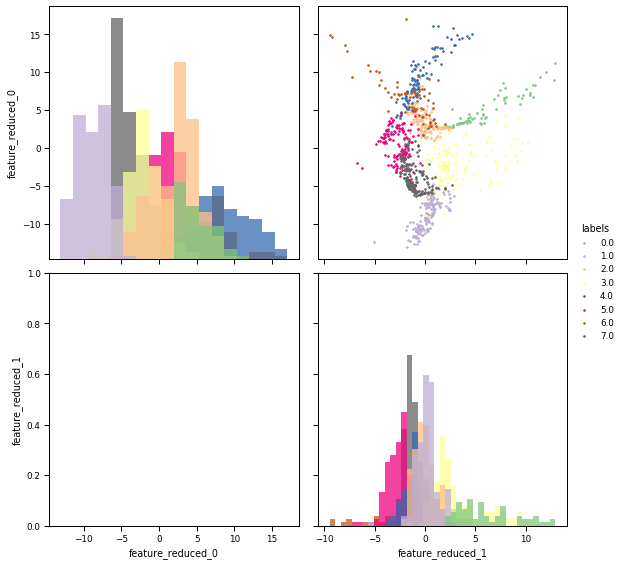

In [24]:
P.scatter_PDF(var_name = var_name + '_reduced')
P.save_BlueCloud('figures/scatter_PDF_EX.png')

__BIC__

In [25]:
corr_dist = 50 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

In [26]:
BIC, BIC_min = BIC_calculation(X=X, coords_dict={'latitude':'lat', 'longitude':'lon'}, 
                               corr_dist=corr_dist,
                               feature_name='feature_reduced', var_name= var_name + "_reduced",
                               Nrun=Nrun, NK=NK)

Figure saved in figures/BIC_EX.png


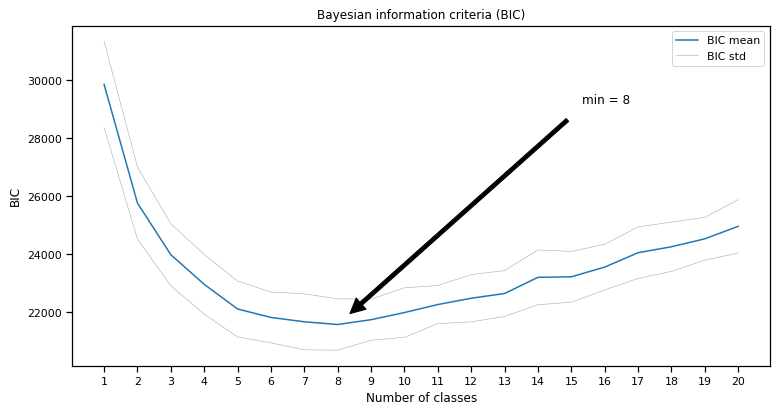

In [27]:
plot_BIC(BIC, NK=NK)
P.save_BlueCloud('figures/BIC_EX.png', bic_fig='yes')

## Plot results
***

In [28]:
P = Plotter_OR(ds_labels, model)

#### __1) Quantiles time series__

Median and other quantiles representation

Figure saved in figures/tseries_struc_EX.png


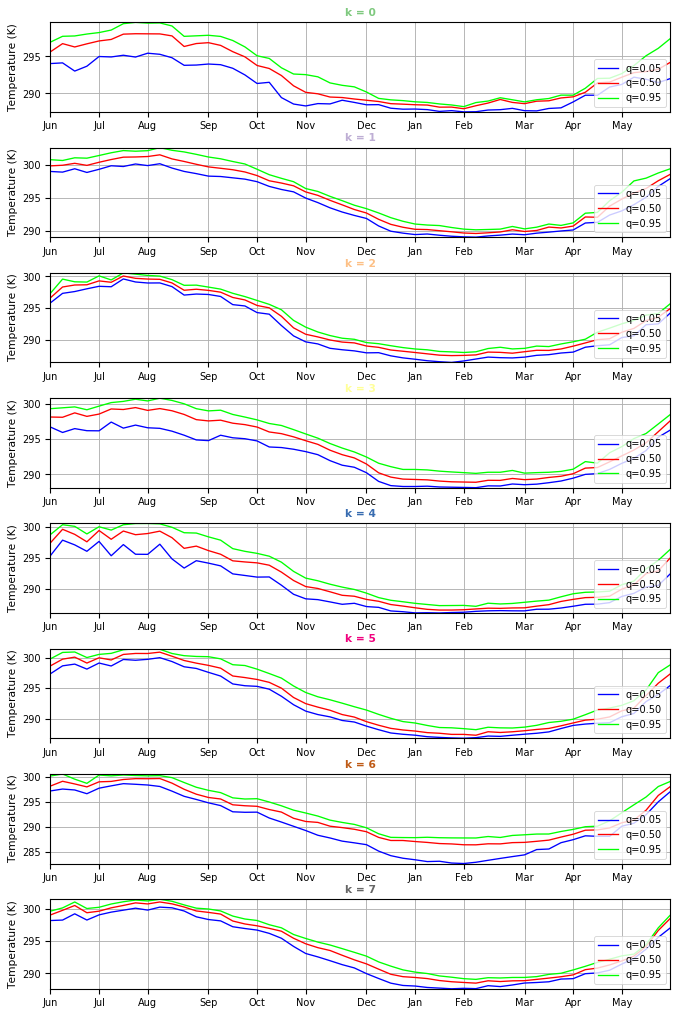

In [29]:
P.tseries_structure(q_variable = var_name + '_Q', start_month=6, ylabel='Temperature (K)')
P.save_BlueCloud('figures/tseries_struc_EX.png')

All median time series in the same plot 

Figure saved in figures/tseries_struc_comp_EX.png


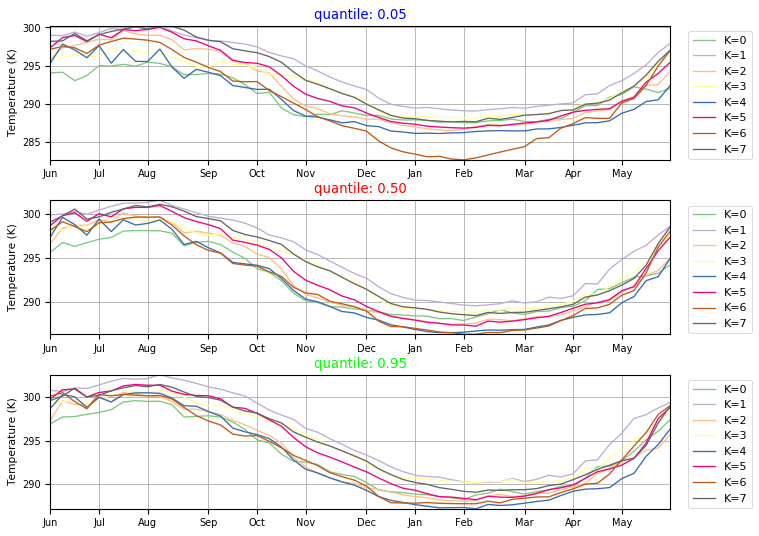

In [30]:
P.tseries_structure_comp(q_variable = var_name + '_Q', plot_q= 'all', ylabel='Temperature (K)', start_month=6)
P.save_BlueCloud('figures/tseries_struc_comp_EX.png')

Quantiles when temperature is scaled (__how we can interpret this figure?__)

In [31]:
P.tseries_structure(q_variable = var_name + '_scaled' + '_Q', start_month=6, ylabel='Temperature (K)')
P.save_BlueCloud('figures/tseries_struc_EX_norm.png')

KeyError: 'analysed_sst_scaled_Q'

#### __2) Spatial distribution of classes__

Figure saved in figures/spatial_distr_EX.png


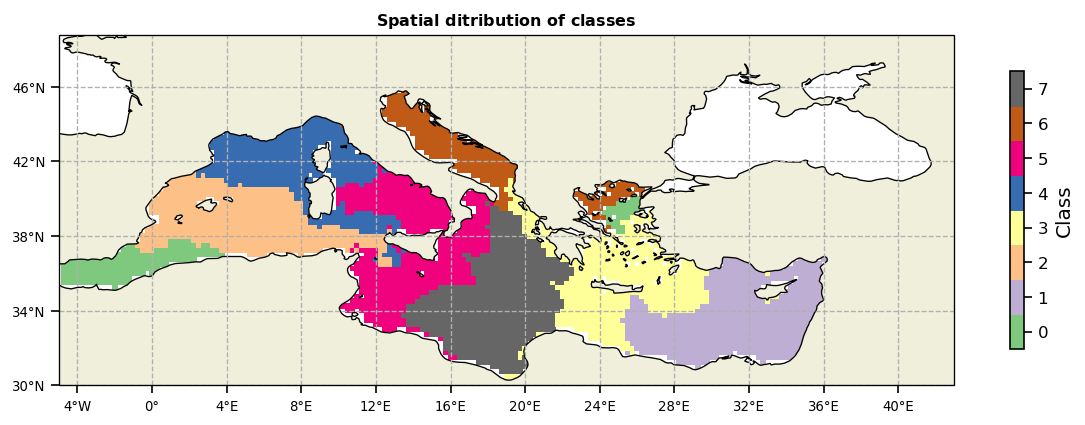

In [32]:
P.spatial_distribution()
P.save_BlueCloud('figures/spatial_distr_EX.png')

#### __3) Robustness__

Figure saved in figures/robustness_EX.png


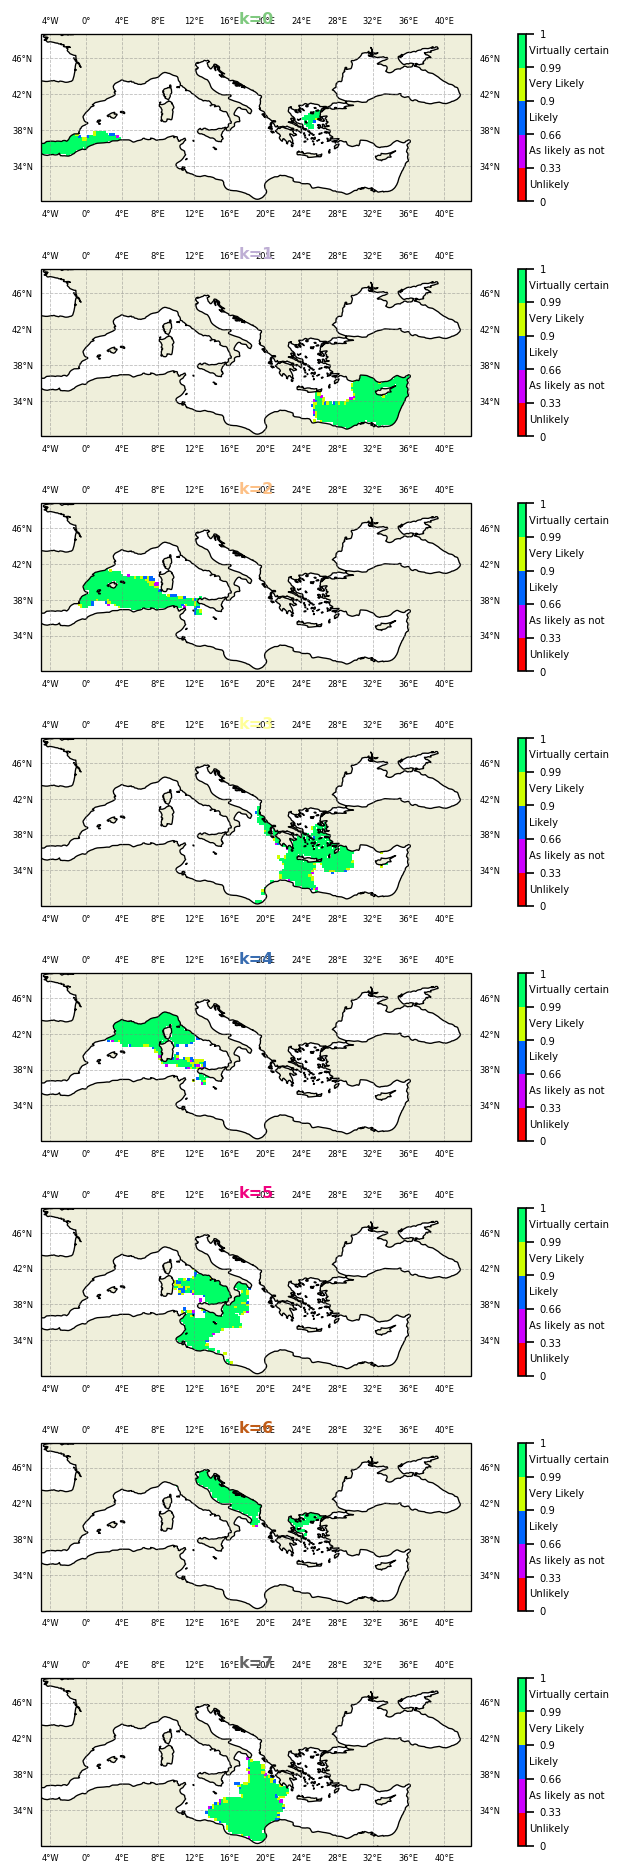

In [33]:
P.plot_robustness()
P.save_BlueCloud('figures/robustness_EX.png')

#### __4) Classes pie chart__

Figure saved in figures/pie_chart_EX.png


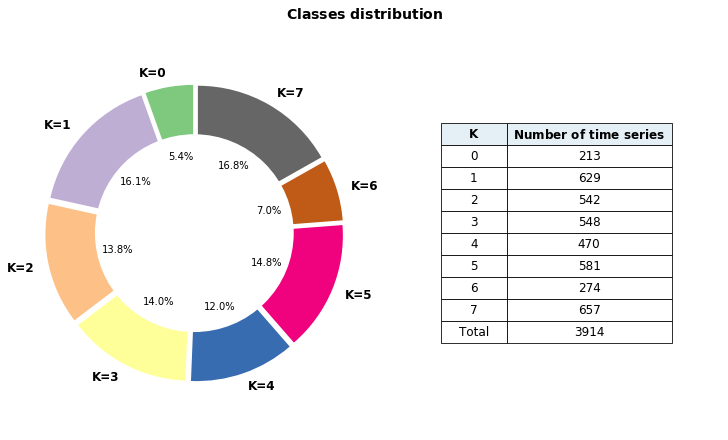

In [34]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')

In [35]:
import joblib
joblib.dump(model, 'models/EX_modelOR_mediterranean_temp_2019_k8.sav')

['models/EX_modelOR_mediterranean_temp_2019_k8.sav']